In [41]:
from cbers4asat import Cbers4aAPI
from datetime import date
import geopandas as gpd
import pandas as pd
from cbers4asat.tools import rgbn_composite
from glob import glob
import matplotlib.pyplot as plt
from os.path import basename
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

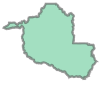

In [42]:
ro = gpd.read_file("./limite_ro/limite_ro.shp")

ro_geometry = ro.unary_union

ro_geometry

In [45]:
inicio = date(2020, 1, 1)
fim = date(2022, 8, 30)

api = Cbers4aAPI("teste@teste.com")

produtos = api.query(location=ro_geometry,
                     initial_date=inicio,
                     end_date=fim,
                     cloud=60,
                     limit=2000,
                     collections=["CBERS4A_WPM_L4_DN"]
                     )

gdf = api.to_geodataframe(produtos)

gdf

,geometry,datetime,path,row,satellite,sensor,cloud_cover,sync_loss,eo:gsd,eo:bands
CBERS4A_WPM23113020220827,"POLYGON ((-67.37380 -12.98960, -67.36670 -14.0...",2022-08-27T15:08:26,231,130,CBERS4A,WPM,40.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM23112920220827,"POLYGON ((-67.20290 -12.19660, -67.19550 -13.2...",2022-08-27T15:08:13,231,129,CBERS4A,WPM,0.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM23112820220827,"POLYGON ((-67.03280 -11.40370, -67.02520 -12.4...",2022-08-27T15:08:00,231,128,CBERS4A,WPM,0.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM23112720220827,"POLYGON ((-66.86340 -10.61020, -66.85570 -11.6...",2022-08-27T15:07:47,231,127,CBERS4A,WPM,20.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM23112520220827,"POLYGON ((-66.51130 -9.02047, -66.52200 -10.06...",2022-08-27T15:07:21,231,125,CBERS4A,WPM,20.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
...,...,...,...,...,...,...,...,...,...,...
CBERS4A_WPM22812320200124,"POLYGON ((-63.79810 -7.43334, -63.79810 -8.480...",2020-01-24T14:41:18,228,123,CBERS4A,WPM,50.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22913020200119,"POLYGON ((-65.76880 -12.98560, -65.76880 -14.0...",2020-01-19T14:45:44,229,130,CBERS4A,WPM,60.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22912920200119,"POLYGON ((-65.59630 -12.19260, -65.59630 -13.2...",2020-01-19T14:45:31,229,129,CBERS4A,WPM,50.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22912820200119,"POLYGON ((-65.42450 -11.39980, -65.42450 -12.4...",2020-01-19T14:45:18,229,128,CBERS4A,WPM,40.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."


<Axes: >

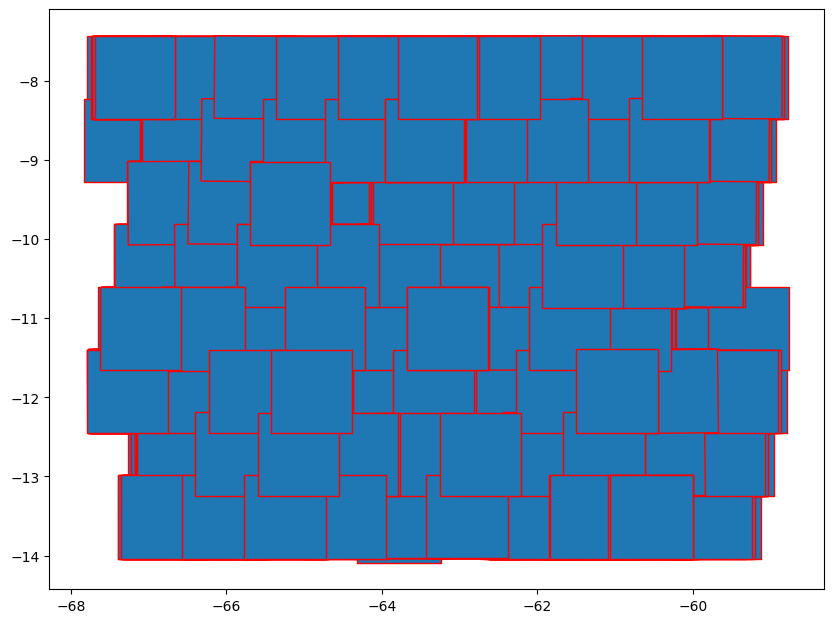

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
ro.plot(ax=ax, color='yellow')
gdf.plot(ax=ax, color=None, edgecolor='red')

<Axes: >

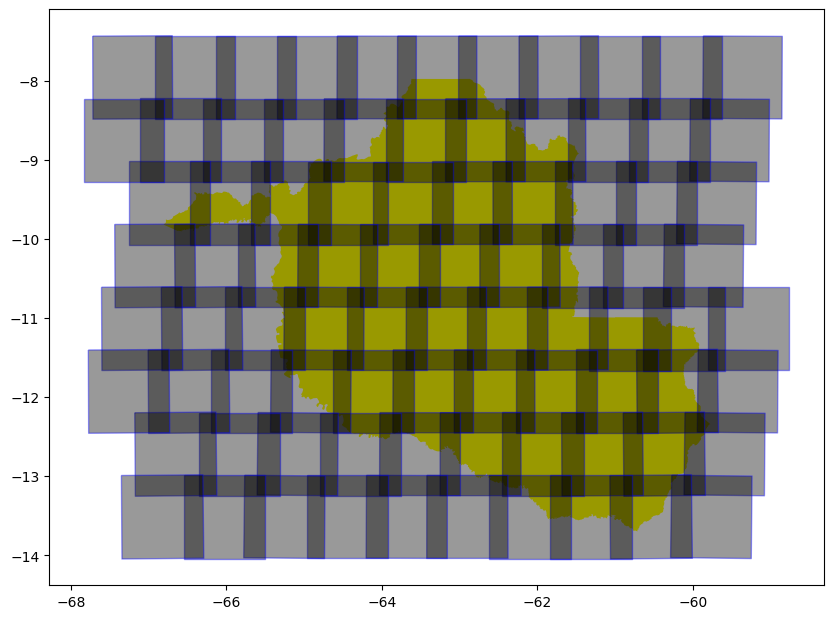

In [47]:
mosaic = gpd.GeoDataFrame()

for group_name, dframe in gdf.groupby(by=['path', 'row']):
    img = dframe.loc[(dframe.cloud_cover == dframe.cloud_cover.min())]

    img = img.loc[(img.datetime == img.datetime.min())]

    mosaic = pd.concat([mosaic, img])

fig, ax = plt.subplots(figsize=(10, 10))
ro.plot(ax=ax, color="yellow")
mosaic.plot(ax=ax, facecolor="black", edgecolor='blue', alpha=0.4)

In [48]:
mosaic.to_crs(epsg=4674, inplace=True)

mosaic.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [49]:
mosaicos_dentro_estado = mosaic.geometry.apply(lambda g: ro.intersects(g))

ro_mosaic = mosaic.merge(right=mosaicos_dentro_estado, left_index=True, right_index=True) \
    .rename(columns={0: 'intersects'})

ro_mosaic = ro_mosaic.loc[ro_mosaic['intersects'] == True]

ro_mosaic.head()

,geometry,datetime,path,row,satellite,sensor,cloud_cover,sync_loss,eo:gsd,eo:bands,intersects
CBERS4A_WPM22212820200727,"POLYGON ((-59.93190 -11.40010, -59.94310 -12.4...",2020-07-27T14:29:44,222,128,CBERS4A,WPM,0.0,0.0,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True
CBERS4A_WPM22212920200727,"POLYGON ((-60.10190 -12.19280, -60.11460 -13.2...",2020-07-27T14:29:57,222,129,CBERS4A,WPM,0.0,0.0,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True
CBERS4A_WPM22213020200727,"POLYGON ((-60.27260 -12.98550, -60.28690 -14.0...",2020-07-27T14:30:09,222,130,CBERS4A,WPM,0.0,0.0,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True
CBERS4A_WPM22312720220805,"POLYGON ((-60.64000 -10.60030, -60.64000 -11.6...",2022-08-05T14:42:55,223,127,CBERS4A,WPM,10.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True
CBERS4A_WPM22312820200621,"POLYGON ((-60.72510 -11.40340, -60.71630 -12.4...",2020-06-21T14:31:43,223,128,CBERS4A,WPM,0.0,0.0,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True


<Axes: >

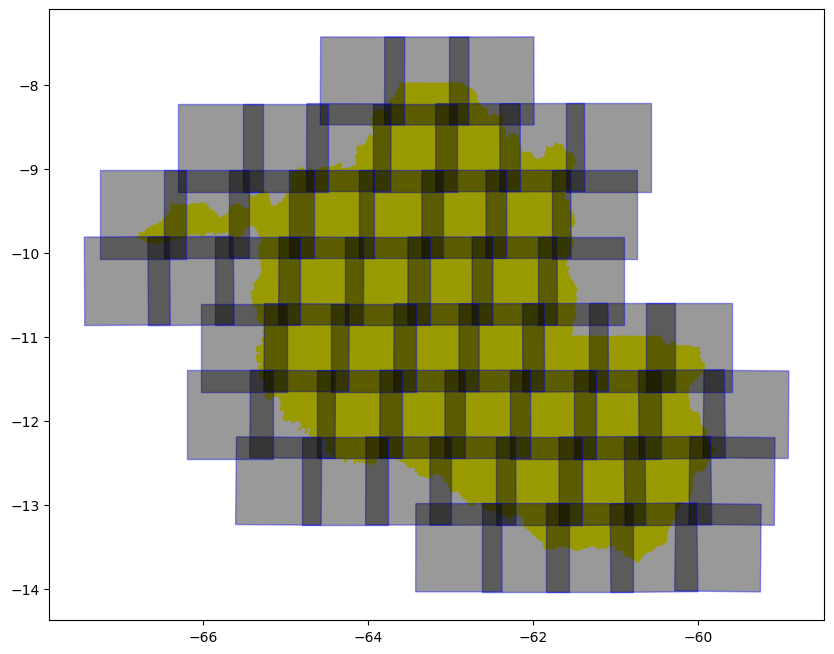

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))

ro.plot(ax=ax, color="yellow")

ro_mosaic.plot(ax=ax, facecolor="black", edgecolor='blue', alpha=0.4)

In [51]:
ro_mosaic.drop(columns=['eo:bands'], inplace=True)

In [52]:
ro_mosaic.to_file("mosaico_cbers4a_ro.geojson", driver='GeoJSON')

In [53]:
ro_mosaic.head()

,geometry,datetime,path,row,satellite,sensor,cloud_cover,sync_loss,eo:gsd,intersects
CBERS4A_WPM22212820200727,"POLYGON ((-59.93190 -11.40010, -59.94310 -12.4...",2020-07-27T14:29:44,222,128,CBERS4A,WPM,0.0,0.0,-1,True
CBERS4A_WPM22212920200727,"POLYGON ((-60.10190 -12.19280, -60.11460 -13.2...",2020-07-27T14:29:57,222,129,CBERS4A,WPM,0.0,0.0,-1,True
CBERS4A_WPM22213020200727,"POLYGON ((-60.27260 -12.98550, -60.28690 -14.0...",2020-07-27T14:30:09,222,130,CBERS4A,WPM,0.0,0.0,-1,True
CBERS4A_WPM22312720220805,"POLYGON ((-60.64000 -10.60030, -60.64000 -11.6...",2022-08-05T14:42:55,223,127,CBERS4A,WPM,10.0,NaN,-1,True
CBERS4A_WPM22312820200621,"POLYGON ((-60.72510 -11.40340, -60.71630 -12.4...",2020-06-21T14:31:43,223,128,CBERS4A,WPM,0.0,0.0,-1,True


In [54]:
api.download(ro_mosaic, bands=['red', 'nir', 'green'], outdir="imagens", with_folder=True)

In [55]:
for dirs in glob("./imagens/*"):
    red, green, blue = '', '', ''
    img_name = ''
    for file in glob(f"{dirs}/*.tif"):
        img_name = basename(file)[:-10]
        if 'BAND3' in file:
            red = file
        elif 'BAND4' in file:
            green = file
        elif 'BAND2' in file:
            blue = file

    rgbn_composite(red=red, green=green, blue=blue, outdir='mosaico_partes', filename=f'{img_name}.tif')

In [56]:
# Definir a projeção de destino
dst_crs = 'EPSG:4674'

# Loop através de cada raster na pasta
for file in glob("./mosaico_partes/*.tif"):

    # Abrir o raster
    with rasterio.open(file) as src:

        # Definir as transformações de origem e destino
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Criar um arquivo de destino para o raster reprojecionado
        with rasterio.open(file, 'w', **kwargs) as dst:
            # Reprojetar o raster
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.cubic)
